<a href="https://colab.research.google.com/github/henk-vd-brink/python-coral-image_classification/blob/master/training_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

!unzip /Dice.v1-raw.voc.zip -d /content/Dice


Archive:  /Dice.v1-raw.voc.zip
 extracting: /content/Dice/README.roboflow.txt  
   creating: /content/Dice/test/
 extracting: /content/Dice/test/IMG_0654_jpeg.rf.5e1a8e701f3990bb646f8e46308975a7.jpg  
 extracting: /content/Dice/test/IMG_0654_jpeg.rf.5e1a8e701f3990bb646f8e46308975a7.xml  
 extracting: /content/Dice/test/IMG_0656_jpeg.rf.28b27f1f51a0d9c772066739e4883d9c.jpg  
 extracting: /content/Dice/test/IMG_0656_jpeg.rf.28b27f1f51a0d9c772066739e4883d9c.xml  
 extracting: /content/Dice/test/IMG_0662_jpeg.rf.478133c2014fb0380c24e222f0252d04.jpg  
 extracting: /content/Dice/test/IMG_0662_jpeg.rf.478133c2014fb0380c24e222f0252d04.xml  
 extracting: /content/Dice/test/IMG_0670_jpeg.rf.d0497981e831018d766c6e34ce59b3d1.jpg  
 extracting: /content/Dice/test/IMG_0670_jpeg.rf.d0497981e831018d766c6e34ce59b3d1.xml  
 extracting: /content/Dice/test/IMG_0690_jpeg.rf.798f6407892dc06ff9cd411d964b97b5.jpg  
 extracting: /content/Dice/test/IMG_0690_jpeg.rf.798f6407892dc06ff9cd411d964b97b5.xml  
 extrac

In [7]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
spec = model_spec.get('efficientdet_lite0')

In [19]:
train_data = object_detector.DataLoader.from_pascal_voc("/content/Dice/train", "/content/Dice/train", label_map={i+1:f"{i+1}" for i in range(0,6)})
validation_data = object_detector.DataLoader.from_pascal_voc("/content/Dice/valid", "/content/Dice/valid", label_map={i+1:f"{i+1}" for i in range(0,6)})
test_data = object_detector.DataLoader.from_pascal_voc("/content/Dice/test", "/content/Dice/test", label_map={i+1:f"{i+1}" for i in range(0,6)})

In [17]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=False, validation_data=validation_data, epochs=50, batch_size=16)

29/29 [==============================] - 284s 9s/step - det_loss: 2.5493 - cls_loss: 1.2659 - box_loss: 0.0257 - reg_l2_loss: 0.0637 - loss: 2.6130 - learning_rate: 0.0090 - gradient_norm: 2.1867 - val_det_loss: 2.3577 - val_cls_loss: 1.1650 - val_box_loss: 0.0239 - val_reg_l2_loss: 0.0637 - val_loss: 2.4215


In [20]:
model.evaluate(test_data)

1/1 [==============================] - 32s 32s/step



{'AP': 0.0007337455,
 'AP50': 0.0018701794,
 'AP75': 0.0,
 'AP_/1': 0.00042931526,
 'AP_/2': 0.0,
 'AP_/3': 0.0,
 'AP_/4': 0.003960396,
 'AP_/5': 0.0,
 'AP_/6': 1.2761749e-05,
 'APl': 0.0015305271,
 'APm': 0.0,
 'APs': -1.0,
 'ARl': 0.021424502,
 'ARm': 0.0,
 'ARmax1': 0.0067860303,
 'ARmax10': 0.0067860303,
 'ARmax100': 0.008301182,
 'ARs': -1.0}

In [21]:
model.export(export_dir='.')

In [22]:
model.evaluate_tflite('model.tflite', test_data)

/content
55/55 [==============================] - 141s 3s/step



{'AP': 0.00016547694,
 'AP50': 0.00042397587,
 'AP75': 0.0,
 'AP_/1': 0.00011277369,
 'AP_/2': 0.0,
 'AP_/3': 0.0,
 'AP_/4': 0.000880088,
 'AP_/5': 0.0,
 'AP_/6': 0.0,
 'APl': 0.0003476018,
 'APm': 0.0,
 'APs': -1.0,
 'ARl': 0.018091168,
 'ARm': 0.0,
 'ARmax1': 0.004862953,
 'ARmax10': 0.0067860303,
 'ARmax100': 0.0067860303,
 'ARs': -1.0}

In [32]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

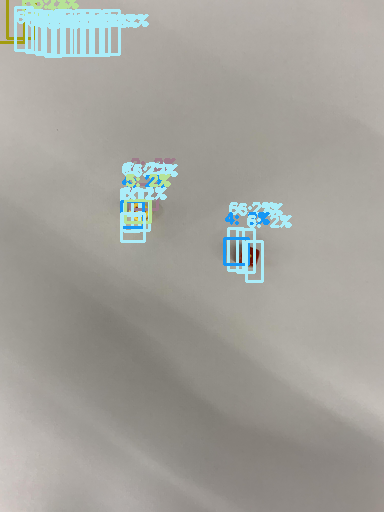

In [33]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "/content/Dice/test/IMG_0654_jpeg.rf.5e1a8e701f3990bb646f8e46308975a7.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.0 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(INPUT_IMAGE_URL)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)